<a href="https://colab.research.google.com/github/ariel-hedvat/AdvancedMLDLCourseAssignments/blob/main/Assignment%20II%20-%20NLP/Assignment_II_Group_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1><font size=6>Assignment 2</font></h1>

  <u>Group members:</u><br>
  - Ariel Hedvat<br>
  - Shiraz Israeli<br>
  - Yuval Bakirov<br>
  - Eitan Bakirov

<br>

This project aims to distinguish dialogue lines from the TV shows Seinfeld and Friends. The dataset includes dialogue text, character information, and show labels. The goal is to build a model trained on dialogue text and show labels, then evaluate its accuracy on a test set.
</div>


<div class="markdown-google-sans">
  <h1><font size=5>Data</font></h1>
</div>

`train.csv` and `test.csv` - TODO<br><br>

<div class="markdown-google-sans">
  <h1><font size=5>Table of Contents</font></h1>

>[Import Libraries](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=-_VBJ0JlYLKI)

>[Loading the data](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=kXwOL606ZfUN)

>[EDA - Exploring Data Analysis](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=P8cTl07AZgyg)



#  Import Libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import os
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [3]:
# Data Loading for Train
url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/Assignment%20II%20-%20NLP/train.csv'
full_train_data = pd.read_csv(url)

# train_with_labels = full_train_data.copy()
# train_data = full_train_data.drop('count', axis=1).copy()
# train_labels = full_train_data['count'].copy()

In [4]:
# Data Loading for Test
url_test = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/Assignment%20II%20-%20NLP/test.csv'
full_test_data = pd.read_csv(url_test)

# test_with_labels = full_test_data.copy()
# test_data = full_test_data.drop('count', axis=1).copy()
# test_labels = full_test_data['count'].copy()

# **EDA - Exploring Data Analysis**

In [5]:
full_train_data

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
...,...,...,...,...,...
70400,Pretty much.,jerry,S05E09,Seinfeld,2
70401,"Oh, well um, not right now. Y'know I’m just g...",phoebe,Season-03 Episode-05-The One With Frank Jr.,Friends,22
70402,"Ooh, I think I wanna trade circles.",phoebe,Season-07 Episode-22-The One With Chandler’s Dad,Friends,7
70403,"Hey, hey, what is this? What's going on here?",jerry,S05E03,Seinfeld,9


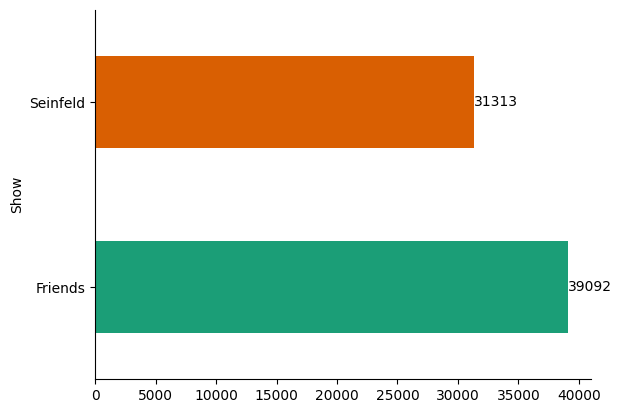

In [7]:
# Grouping by 'Show' and getting size
grouped_data = full_train_data.groupby('Show').size()

# Plotting the grouped data
ax = grouped_data.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding count numbers near the plots
for i, count in enumerate(grouped_data):
    ax.text(count + 0.1, i, str(count), va='center')  # Adjust 0.1 to place the number slightly away from the bar

plt.show()